In [1]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tifffile
from csbdeep.utils import normalize
from joblib import Parallel, delayed
from stardist.models import StarDist2D, StarDist3D
from tqdm.notebook import tqdm

2024-09-26 14:57:52.973692: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-26 14:57:52.973794: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-26 14:57:52.973815: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-26 14:57:53.539713: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("GPUs detected: ", tf.config.experimental.list_physical_devices("GPU"))

GPUs detected:  []


In [3]:
# stardist does not offer a 'list' of pretrained models. calling StarDist2D.from_pretrained() just prints available models to console
# so we define a list of models here to check against
DEFAULT_MODELS_2D = {
    "2D_versatile_fluo",
    "2D_versatile_he",
    "2D_paper_dsb2018",
}
# no pretrained 3D models are available in stardist at the moment. They have expressed the desire to add them in the future
# https://stardist.net/faq/#is-there-a-pretrained-model-for-3d-or-do-you-plan-to-release-one
DEFAULT_MODELS_3D = set()


def preprocess_image(image):
    # keep preprocessing minimal, stardist by-and-large is robust to _natural_ intensity variations,
    # and excessive preprocessing can lead to segmentation artifacts
    image, crop_mask = square_crop(image, return_mask=True)
    image = cv2.createCLAHE(clipLimit=6, tileGridSize=(8, 8)).apply(image)
    return image, crop_mask


def square_crop(image, crop_axes=(-2, -1), return_mask=False):
    if len(crop_axes) < 2:
        raise ValueError(
            "square_crop needs at least two axes to crop from. The smallest axis size determines the side length of the resultant image"
        )

    crop_axes = np.array(crop_axes)
    # convert negative axes to positive
    crop_axes = crop_axes % image.ndim

    crop_ax_sizes = [image.shape[ax] for ax in crop_axes]
    min_size = min(crop_ax_sizes)

    # by default, keep everything from each axis
    crop_slices = [np.s_[:]] * image.ndim
    for ax in crop_axes:
        size_delta = image.shape[ax] - min_size
        crop_amount = size_delta // 2
        i_min = crop_amount
        i_max = image.shape[ax] - (size_delta - crop_amount)
        # overwrite the default slice with the cropped slice
        crop_slices[ax] = np.s_[i_min:i_max]

    crop_slices = tuple(crop_slices)
    cropped_image = image[crop_slices]
    if return_mask:
        crop_mask = np.zeros_like(image, dtype=bool)
        crop_mask[crop_slices] = True
        return cropped_image, crop_mask
    else:
        return cropped_image


def parallel_load_files(files, channel, threads=1):
    # since this is io, threading is sufficient and has lower overhead
    # return as generator to avoid loading all files into memory at once - they will be loaded on demand,
    # hopefully as fast as stardist can handle. Nonetheless, can still be rate limitting if cluster is slow
    image_generator = Parallel(
        n_jobs=threads, backend="threading", return_as="generator"
    )(delayed(tifffile.imread)(file, key=channel) for file in files)
    return image_generator


def process_image(stardist_model, raw_image, scale=1):
    image, crop_mask = preprocess_image(raw_image)
    egg_seg = stardist_seg(model=stardist_model, image=image, scale=scale)

    uncropped_egg_seg = np.zeros_like(raw_image, dtype=egg_seg.dtype)
    uncropped_egg_seg[crop_mask] = egg_seg.flat
    # uncropped_egg_seg now same shape as raw_image
    return uncropped_egg_seg


def stardist_seg(model, image, scale):
    # strictly speaking a pre-processing step, but it's used in all stardist examples and was used for the model training,
    # so it's added here
    # it also converts to float32 by default
    image = normalize(image)
    seg, _ = model.predict_instances(image, scale=scale)
    return seg


def load_stardist_model(model_name):
    # stardist automatically loads the model onto gpu
    # if no gpu is present, cpus will be used
    if model_name in DEFAULT_MODELS_2D:
        model = StarDist2D.from_pretrained(model_name)
    elif model_name in DEFAULT_MODELS_3D:
        model = StarDist3D.from_pretrained(model_name)
    else:
        raise ValueError(
            f"Model {model_name} not found in default stardist models. Custom models not yet supported."
        )
    return model


stardist_model = load_stardist_model("2D_versatile_he")

Found model '2D_versatile_he' for 'StarDist2D'.


5294730/5294730 [==============================] - 0s 0us/step
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


In [ ]:
filemap = pd.read_csv(
    "/home/bgusev/new_towbin/shared/bgusev/stardist_egg_seg/xgboost_training/training_data/filemap.csv"
)
print(len(filemap))
filemap.head()

In [ ]:
idx = 10
test_image = tifffile.imread(filemap.iloc[idx]["training_image"])
raw = tifffile.imread(filemap.iloc[idx]["raw"], key=1)
local_raw = tifffile.imread(filemap.iloc[idx]["_raw_local"], key=1)
manual_seg = tifffile.imread(filemap.iloc[idx]["manual_seg"])

out = process_image(stardist_model, test_image, scale=0.5)

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
[ax.axis("off") for ax in axs.flat]
[ax.imshow(i) for ax, i in zip(axs.flat, [raw, local_raw, manual_seg, test_image, out])]

In [ ]:
stardist_dir = (
    Path(
        "/mnt/towbin.data/shared/bgusev/stardist_egg_seg/xgboost_training/training_data"
    )
    / "stardist_seg"
)
stardist_dir.mkdir(exist_ok=True)
filemap["stardist_seg"] = [
    str(stardist_dir / (Path(f).name)) for f in filemap["training_image"]
]

filemap.head()

In [ ]:
in_files = parallel_load_files(
    filemap["training_image"].values, channel=None, threads=8
)

for image, out_file in tqdm(zip(in_files, filemap["stardist_seg"]), total=len(filemap)):
    # img = tifffile.imread(in_file)
    sd_seg = process_image(stardist_model, image, scale=0.5)
    assert image.shape == sd_seg.shape
    tifffile.imwrite(out_file, sd_seg)

In [12]:
filemap.to_csv(
    "/home/bgusev/new_towbin/shared/bgusev/stardist_egg_seg/xgboost_training/training_data/filemap.csv",
    index=False,
)



NameError: name 'filemap' is not defined

In [ ]:
from stardist.models import StarDist2D
from tifffile import imread
import matplotlib.pyplot as plt

# Load the pre-trained '2D_versatile_he' model
model = StarDist2D.from_pretrained('2D_versatile_he')

# Load the image
image_path = '/mnt/towbin.data/shared/smarin/data/20241707_souvik_w318_ev_mex3_squid/training_data_egg/brightfield/Time00202_Point0044_470nm,565nm,BF_Seq34294.ome.tiff'
img = imread(image_path)

# Ensure the image is normalized if needed (assuming it's already in uint8 and grayscale)
if img.dtype == np.uint8:
    img = img / 255.0  # Normalize to [0, 1] if not already

# Predict instances
labels, details = model.predict_instances(img, axes='YX')

# Visualize the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(labels, cmap='nipy_spectral')
plt.title('Predicted Labels')
plt.axis('off')

plt.show()


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/Time00202_Point0044_470nm,565nm,BF_Seq34294.ome.tiff'

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.477586, nms_thresh=0.4.


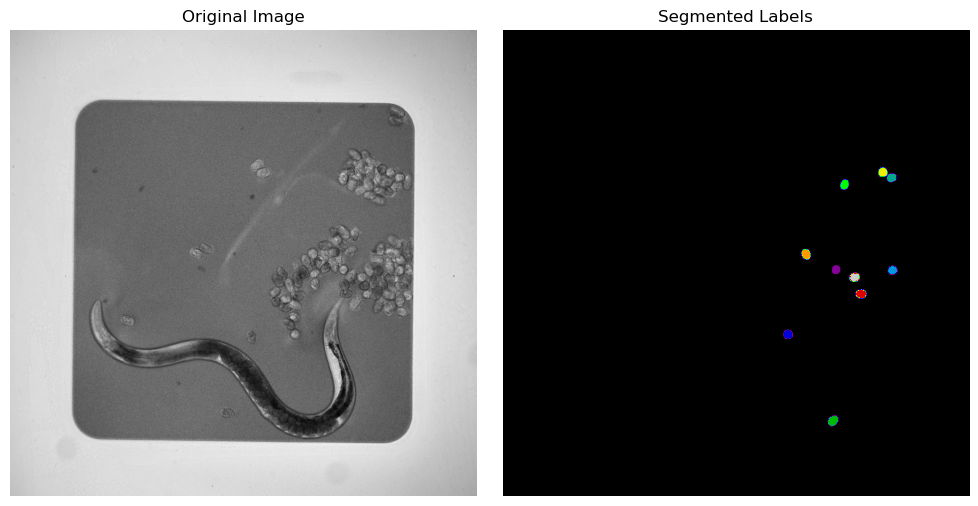

In [2]:
from stardist.models import StarDist2D
from tifffile import imread
import matplotlib.pyplot as plt
import numpy as np

# Path to the model directory where 'weights_best.h5', 'config.json', and 'thresholds.json' are stored
model_dir = '/mnt/towbin.data/shared/smarin/models/brightfield_egg/training_data_star'  # Replace with your actual model directory

# Load the trained model
model = StarDist2D(None, name='test2', basedir=model_dir)

# Load a new image for segmentation
image_path = '/mnt/towbin.data/shared/smarin/data/20241707_souvik_w318_ev_mex3_squid/raw/Time00118_Point0048.tiff'  # Replace with your new image path
img = imread(image_path)

# Ensure that the image has the correct format (e.g., YXC or single channel)
# If the image has multiple channels (CXY), use only the relevant channel (e.g., the last channel)
if img.ndim == 3 and img.shape[0] == 3:  # CXY format with 3 channels
    img = img[-1, :, :]  # Take only the last channel
elif img.ndim == 3 and img.shape[-1] == 3:  # YXC format with 3 channels
    img = img[..., -1]  # Take only the last channel

# Normalize the image (optional but recommended)
img = img.astype(np.float32) / np.max(img)

# Perform segmentation using the model
labels, details = model.predict_instances(img)

# Visualize the segmentation result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(labels, cmap='nipy_spectral')
plt.title('Segmented Labels')
plt.axis('off')

plt.tight_layout()
plt.show()